In [1]:
import torch
import torchvision
from torch import nn
import time
import torch
import torch.nn.functional as F
from torch import optim
from torch import nn
from einops import rearrange

import numpy as np
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
#残差模块，放在每个前馈网络和注意力之后
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

#layernorm归一化,放在多头注意力层和激活函数层。用绝对位置编码的BERT，layernorm用来自身通道归一化
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)
#放置多头注意力后，因为在于多头注意力使用的矩阵乘法为线性变换，后面跟上由全连接网络构成的FeedForward增加非线性结构
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x):
        return self.net(x)
#多头注意力层，多个自注意力连起来。使用qkv计算
class Attention(nn.Module):
    def __init__(self, dim, heads=8):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5

        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Linear(dim, dim)

    def forward(self, x, mask = None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x)
        q, k, v = rearrange(qkv, 'b n (qkv h d) -> qkv b h n d', qkv=3, h=h)

        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale

        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, float('-inf'))
            del mask

        attn = dots.softmax(dim=-1)

        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

In [3]:
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim)))
            ]))

    def forward(self, x, mask=None):
        for attn, ff in self.layers:
            x = attn(x, mask=mask)
            x = ff(x)
        return x
#将图像切割成一个个图像块,组成序列化的数据输入Transformer执行图像分类任务。
class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels=3):
        super().__init__()
        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2

        self.patch_size = patch_size

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = Transformer(dim, depth, heads, mlp_dim)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, num_classes)
        )

    def forward(self, img, mask=None):
        p = self.patch_size

        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = p, p2 = p)
        x = self.patch_to_embedding(x)

        cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.transformer(x, mask)

        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)



In [4]:
torch.manual_seed(42)

DOWNLOAD_PATH = '/data/mnist'
BATCH_SIZE_TRAIN = 100
BATCH_SIZE_TEST = 1000

In [5]:
transform_mnist = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))])

train_set = torchvision.datasets.MNIST(DOWNLOAD_PATH, train=True, download=True,
                                       transform=transform_mnist)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True, num_workers=4)

test_set = torchvision.datasets.MNIST(DOWNLOAD_PATH, train=False, download=True,
                                      transform=transform_mnist)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE_TEST, shuffle=True, num_workers=4)

In [6]:
def train_epoch(model, optimizer, data_loader, loss_history):
    total_samples = len(data_loader.dataset)
    model.train()

    for i, (data, target) in enumerate(data_loader):
        optimizer.zero_grad()
        data, target = data.to(device), target.to(device)
        output = F.log_softmax(model(data), dim=1)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
            loss_history.append(loss.item())


def evaluate(model, data_loader, loss_history):
    model.eval()

    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = F.log_softmax(model(data), dim=1)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)

            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()

    avg_loss = total_loss / total_samples
    loss_history.append(avg_loss)
    print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')

In [7]:
N_EPOCHS = 15

start_time = time.time()
'''
patch大小为 7x7（对于 28x28 图像，这意味着每个图像 4 x 4 = 16 个patch）、10 个可能的目标类别（0 到 9）和 1 个颜色通道（因为图像是灰度）。
在网络参数方面，使用了 64 个单元的维度，6 个 Transformer 块的深度，8 个 Transformer 头，MLP 使用 128 维度。'''
model = ViT(image_size=28, patch_size=7, num_classes=10, channels=1,
            dim=64, depth=6, heads=8, mlp_dim=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.003)

weights = []

train_loss_history, test_loss_history = [], []
for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    train_epoch(model, optimizer, train_loader, train_loss_history)
    evaluate(model, test_loader, test_loss_history)
    if epoch % 3 == 0:
        torch.save(model.state_dict(), f'ckpts\model_v1_epoch_{epoch}')
        weights.append(f'ckpts\model_v1_epoch_{epoch}')

print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')

Epoch: 1
[    0/60000 (  0%)]  Loss: 2.3308
[10000/60000 ( 17%)]  Loss: 0.5572
[20000/60000 ( 33%)]  Loss: 0.3044
[30000/60000 ( 50%)]  Loss: 0.1771
[40000/60000 ( 67%)]  Loss: 0.1610
[50000/60000 ( 83%)]  Loss: 0.0980

Average test loss: 0.1432  Accuracy: 9537/10000 (95.37%)

Epoch: 2
[    0/60000 (  0%)]  Loss: 0.1393
[10000/60000 ( 17%)]  Loss: 0.1459
[20000/60000 ( 33%)]  Loss: 0.1031
[30000/60000 ( 50%)]  Loss: 0.0899
[40000/60000 ( 67%)]  Loss: 0.2304
[50000/60000 ( 83%)]  Loss: 0.1841

Average test loss: 0.1147  Accuracy: 9660/10000 (96.60%)

Epoch: 3
[    0/60000 (  0%)]  Loss: 0.0348
[10000/60000 ( 17%)]  Loss: 0.2604
[20000/60000 ( 33%)]  Loss: 0.1188
[30000/60000 ( 50%)]  Loss: 0.2181
[40000/60000 ( 67%)]  Loss: 0.1190
[50000/60000 ( 83%)]  Loss: 0.1363

Average test loss: 0.0989  Accuracy: 9705/10000 (97.05%)

Epoch: 4
[    0/60000 (  0%)]  Loss: 0.1159
[10000/60000 ( 17%)]  Loss: 0.0699
[20000/60000 ( 33%)]  Loss: 0.1349
[30000/60000 ( 50%)]  Loss: 0.0736
[40000/60000 ( 67

In [8]:
weights = np.array(weights)
np.save('weightpath.npy', weights)
weights = weights.tolist()

In [9]:
weights = np.load('weightpath.npy')
weights = weights.tolist()

In [10]:
train_subset = torch.utils.data.Subset(train_set, range(200)) 
test_subset =  torch.utils.data.Subset(test_set, range(20))

train_tracin_loader = torch.utils.data.DataLoader(train_subset, batch_size=1, shuffle=False, num_workers=4)

test_tracin_loader = torch.utils.data.DataLoader(test_subset, batch_size=1, shuffle=False, num_workers=4)

In [11]:
def calculate_tracin_score(
    model: torch.nn.Module,
    weights_paths,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    nu_for_each_epoch: None
):
        
    LR = nu_for_each_epoch

    score_matrix = np.zeros((len(train_dataloader), len(test_dataloader)))
    
    for train_id, (x_train, y_train) in enumerate(train_dataloader):
        x_train, y_train = x_train.to(device), y_train.to(device)
        # print(train_id)
        print('TracIn:', round(train_id)/2, '%')
        for test_id, (x_test, y_test) in enumerate(test_dataloader):
            # print(test_id)
            x_test, y_test = x_test.to(device), y_test.to(device)
            grad_sum = 0
            
            for w in weights_paths:
                model = ViT(image_size=28, patch_size=7, num_classes=10, channels=1,
            dim=64, depth=6, heads=8, mlp_dim=128).to(device)
                model.load_state_dict(torch.load(w)) # checkpoint
                model.eval()
                y_pred = model(x_train) # pred
                y_pred = F.log_softmax(y_pred, dim=1)
                loss = F.nll_loss(y_pred, y_train, reduction='sum')
                loss.backward() # back
                train_grad = torch.cat([param.grad.reshape(-1) for param in model.parameters()])
 
                model = ViT(image_size=28, patch_size=7, num_classes=10, channels=1,
            dim=64, depth=6, heads=8, mlp_dim=128).to(device)
                model.load_state_dict(torch.load(w)) # checkpoint
                model.eval()
                y_pred = model(x_test) # pred
                y_pred = F.log_softmax(y_pred, dim=1)
                loss = F.nll_loss(y_pred, y_test, reduction='sum')
                loss.backward() # back
                test_grad = torch.cat([param.grad.reshape(-1) for param in model.parameters()])

                train_grad, test_grad = train_grad.to('cpu'), test_grad.to('cpu')
                grad_sum += LR * np.dot(train_grad, test_grad) # scalar mult, TracIn formula
            
            score_matrix[train_id][test_id] = grad_sum
    
    
    return score_matrix

In [12]:
matrix = calculate_tracin_score(model=ViT(image_size=28, patch_size=7, num_classes=10, channels=1,
            dim=64, depth=6, heads=8, mlp_dim=128), 
                       weights_paths=weights, 
                       train_dataloader=train_tracin_loader, test_dataloader=test_tracin_loader, nu_for_each_epoch=0.003)

TracIn: 0.0 %
TracIn: 0.5 %
TracIn: 1.0 %
TracIn: 1.5 %
TracIn: 2.0 %
TracIn: 2.5 %
TracIn: 3.0 %
TracIn: 3.5 %
TracIn: 4.0 %
TracIn: 4.5 %
TracIn: 5.0 %
TracIn: 5.5 %
TracIn: 6.0 %
TracIn: 6.5 %
TracIn: 7.0 %
TracIn: 7.5 %
TracIn: 8.0 %
TracIn: 8.5 %
TracIn: 9.0 %
TracIn: 9.5 %
TracIn: 10.0 %
TracIn: 10.5 %
TracIn: 11.0 %
TracIn: 11.5 %
TracIn: 12.0 %
TracIn: 12.5 %
TracIn: 13.0 %
TracIn: 13.5 %
TracIn: 14.0 %
TracIn: 14.5 %
TracIn: 15.0 %
TracIn: 15.5 %
TracIn: 16.0 %
TracIn: 16.5 %
TracIn: 17.0 %
TracIn: 17.5 %
TracIn: 18.0 %
TracIn: 18.5 %
TracIn: 19.0 %
TracIn: 19.5 %
TracIn: 20.0 %
TracIn: 20.5 %
TracIn: 21.0 %
TracIn: 21.5 %
TracIn: 22.0 %
TracIn: 22.5 %
TracIn: 23.0 %
TracIn: 23.5 %
TracIn: 24.0 %
TracIn: 24.5 %
TracIn: 25.0 %
TracIn: 25.5 %
TracIn: 26.0 %
TracIn: 26.5 %
TracIn: 27.0 %
TracIn: 27.5 %
TracIn: 28.0 %
TracIn: 28.5 %
TracIn: 29.0 %
TracIn: 29.5 %
TracIn: 30.0 %
TracIn: 30.5 %
TracIn: 31.0 %
TracIn: 31.5 %
TracIn: 32.0 %
TracIn: 32.5 %
TracIn: 33.0 %
TracIn: 33.5 %


In [13]:
np.save('tracinmatrix.npy', matrix)

In [14]:
def imshow(imgs):
    fig = plt.figure(figsize=(8, 2))

    fig.add_subplot(1, 3, 1)
    plt.imshow(imgs[0], cmap='gray', interpolation='none') # train observation
    fig.add_subplot(1, 3, 2)
    plt.imshow(imgs[1], cmap='gray', interpolation='none') # highest TracIn on test
    fig.add_subplot(1, 3, 3)
    plt.imshow(imgs[2], cmap='gray', interpolation='none') # lowest TracIn on test
    plt.show()

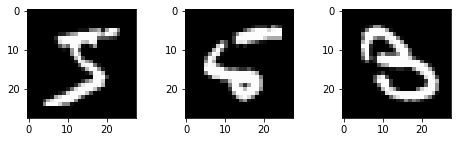

	 5 		 5 			 3



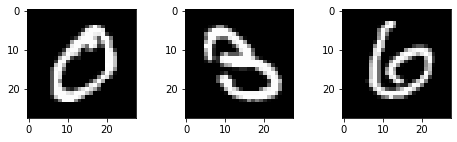

	 0 		 3 			 6



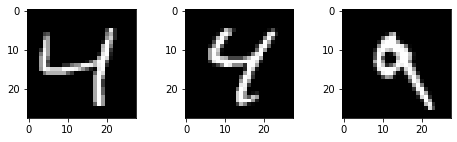

	 4 		 4 			 9



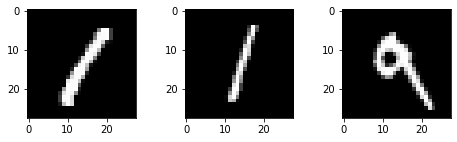

	 1 		 1 			 9



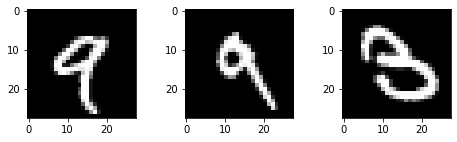

	 9 		 9 			 3



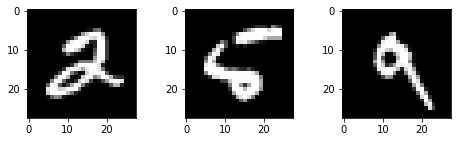

	 2 		 5 			 9



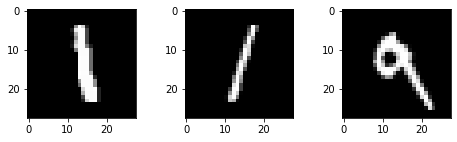

	 1 		 1 			 9



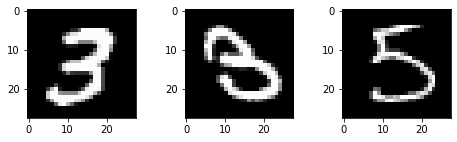

	 3 		 3 			 5



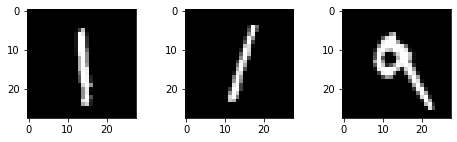

	 1 		 1 			 9



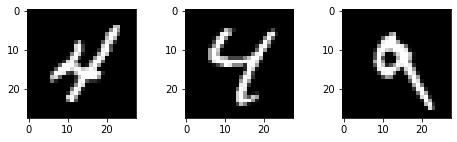

	 4 		 4 			 9



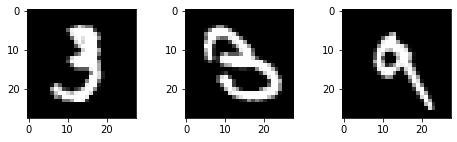

	 3 		 3 			 9



In [16]:
for train_id, (x_train, y_train) in enumerate(train_tracin_loader):
    row = matrix[train_id, :]
    max_ind = row.argmax()
    min_ind = row.argmin()
    imshow([train_subset[train_id][0][0], test_subset[max_ind][0][0], test_subset[min_ind][0][0]])
    print('\t', train_subset[train_id][1], '\t\t', test_subset[max_ind][1], '\t\t\t', test_subset[min_ind][1])
    print()
    if train_id > 9:
      break

# 图中每行第一个为训练样本，第二个和第三个分别为当前训练样本对所有测试样本求TracIn值的argmax和argmin